In [3]:
import glob
import os
import numpy as np
from typing import Dict, List
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.trials import align_trials, select_trials
import pandas as pd
from scipy import stats
from joblib import Parallel, delayed
from tqdm import tqdm
from ephysvibe.stats import smetrics
seed = 1997

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import re
from collections import defaultdict
import itertools
import pickle

In [5]:
def get_neu_align (path,params,sp_sample=False):

    neu = NeuronData.from_python_hdf5(path)
    for it in params:
        sp, mask = neu.align_on(
                select_block=it["select_block"],
                select_pos=it["inout"],
                event=it["event"],
                time_before=it["time_before"],
                error_type=0,
            )
        endt=it['time_before']+it['end']
        stt=it['time_before']+it['st']
        setattr(neu, it['sp'], np.array(sp[:,:endt],dtype=it["dtype_sp"]))
        setattr(neu, it['mask'], np.array(mask,dtype=it["dtype_mask"]))
        setattr(neu, 'st_'+it["event"]+'_'+it["inout"], np.array(stt,dtype=int))
        setattr(neu, 'time_before_'+it["event"]+'_'+it["inout"], np.array(it['time_before'],dtype=int))

    if ~sp_sample: setattr(neu, 'sp_samples', np.array([]))

    return neu

In [6]:
# Define parameters
# Create one population per session
filepath = "D:/data/session_struct/*/neurons/*neu.h5"
path_list = glob.glob(filepath)
# Group paths per session 
date_pattern = r'\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}'
# Dictionary to group paths by date and time
grouped_paths = defaultdict(list)
# Iterate over the paths
for path in path_list:
    # Extract the date and time
    match = re.search(date_pattern, path)
    if match:
        date_time = match.group()
        grouped_paths[date_time].append(path)

In [7]:
# Parameters to preprocesss the spikes
params =[{'inout':'in','sp':'sample_on_in','mask':'mask_in','event':'sample_on','time_before':300,'st':0,'end':1550,'select_block':1,'win':100,'dtype_sp':np.int8,'dtype_mask':bool},
         {'inout':'out','sp':'sample_on_out','mask':'mask_out','event':'sample_on','time_before':300,'st':0,'end':1550,'select_block':1,'win':100,'dtype_sp':np.int8,'dtype_mask':bool}]
# TODO: add parameters to align also to test on
date_time = '2022-12-14_10-50-49'

In [8]:

datepaths = grouped_paths[date_time]
population = Parallel(n_jobs=-1)(
    delayed(get_neu_align)(neu,params) for neu in tqdm(datepaths)
)

100%|██████████| 110/110 [00:58<00:00,  1.87it/s]


In [9]:
comment= str(params)
popu = PopulationData(population, comment=comment)
popu.to_python_hdf5('res/test.h5')

In [10]:
popu=PopulationData.from_python_hdf5('res/test.h5')

In [11]:
def get_fr(neu,inout,sample,st,end,win=100):
    res = {}
    mask = getattr(neu, "mask_" + inout)
    sp = getattr(neu, "sample_on_" + inout)
    fr = firing_rate.moving_average(data=sp, win=win, step=1)[:, st:end]
    sample_id = neu.sample_id[mask]
    fr_samples = select_trials.get_sp_by_sample(fr, sample_id, [sample])
    frs = fr_samples[str(sample)]
    nzeros = np.sum(np.sum(frs[:,200:],axis=0)==0)
    print(nzeros)
    if np.logical_or(nzeros>25,np.mean(frs[:,200:])*1000<5):
        return None
    res['id'] = neu.cluster_group+'_'+str(neu.cluster_number)
    res['area'] = neu.area
    res['fr'] = frs
    return res

In [12]:
win=100
inout = "in"
sample = 11
st=100
end = 1150

In [13]:
popu_fr = popu.execute_function(
    get_fr, win=win, inout=inout, sample=sample, st=st, end=end, n_jobs=-1, ret_df=False
)

100%|██████████| 110/110 [00:04<00:00, 26.03it/s]


In [14]:
fr_dicts_only = [item for item in popu_fr if isinstance(item, dict)]
len(fr_dicts_only)

43

In [15]:
def compute_correlation(popu_fr,n1,n2):
    neu1=popu_fr[n1]
    neu2=popu_fr[n2]
    if np.logical_or(neu1 is None, neu2 is None):
        return None
    trial_dur=neu1['fr'].shape[1]
    corr = np.corrcoef(neu1['fr'].T,neu2['fr'].T)
    #corr,p_val = stats.spearmanr(neu1['fr'],neu2['fr'])
    if np.all(np.isnan(corr)):
        corr = np.array([corr],dtype=np.float16)
        #p_val = np.array([p_val],dtype=np.float16)
    else:
        #p_val=p_val[:trial_dur,trial_dur:].astype(np.float16)
        corr = corr.round(decimals=3)[:trial_dur,trial_dur:].astype(np.float16)
    #corr = np.corrcoef(np.array(t_neus1).T,np.array(t_neus2).T)
    areas=neu1['area'] +'_'+neu2['area']
    return {'areas':areas,'y':neu1['id'],'x':neu2['id'],'corr':corr}#,'p':p_val}

In [16]:
numbers=range(len(fr_dicts_only))
pairs = list(itertools.combinations(numbers, 2)) # Compute each pair in parallel
len(pairs)

903

In [17]:
res = Parallel(n_jobs=-1)(
    delayed(compute_correlation)(fr_dicts_only, n1,n2) for n1,n2 in tqdm(pairs[:100])
)
res_dicts_only = [item for item in res if isinstance(item, dict)]
with open("corr_"+date_time+".pkl", "wb") as fp: 
    pickle.dump(res_dicts_only, fp)

100%|██████████| 100/100 [00:13<00:00,  7.57it/s]


In [18]:
with open("./corr_"+date_time+".pkl", 'rb') as handle:
    corrlist = pickle.load(handle)

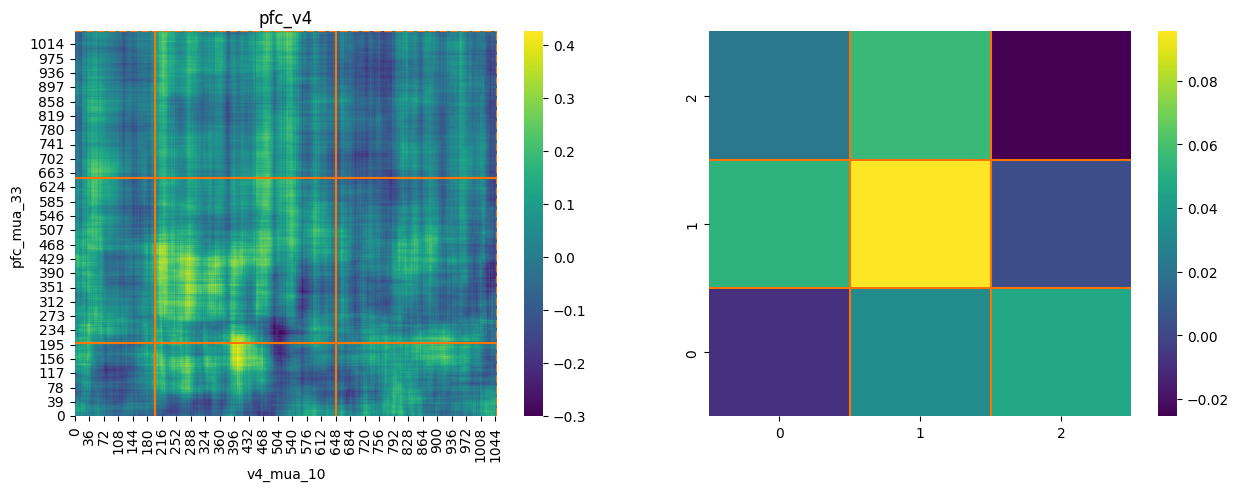

In [23]:
slices = [slice(0, 200), slice(200, 650), slice(650, None)]
for icorr in corrlist[50:51]:
    if np.all(np.isnan(icorr['corr'])): continue 
    f,ax=plt.subplots(1,2,figsize=(15,5))
    corrmat=icorr['corr']
    _=sns.heatmap(icorr['corr'],cmap='viridis',ax=ax[0])
    mean_corr = np.empty((3, 3))
    corrmat=corrmat.astype(np.float32)
    for i in range(3):
        for j in range(3):
            mean_corr[i, j] = np.nanmean(corrmat[slices[i], slices[j]])

    _=sns.heatmap(mean_corr,cmap='viridis',ax=ax[1])
    ax[0].axes.invert_yaxis()
    ax[1].axes.invert_yaxis()
    ax[0].vlines([200,650,650+400],0,2100,'#FF7400',['-','-','--'])
    ax[0].hlines([200,650,650+400],0,2100,'#FF7400',['-','-','--'])
    ax[1].vlines([1,2],0,2100,'#FF7400',['-','-'])
    ax[1].hlines([1,2],0,2100,'#FF7400',['-','-'])
    areas = icorr['areas'].split('_')
    y_label = areas[0]+'_'+icorr['y']
    x_label = areas[1]+'_'+icorr['x']
    ax[0].set(xlabel=x_label,ylabel=y_label,title=icorr['areas'])

In [15]:
icorr['areas']+icorr['x']+


0.4332483

In [38]:
icorr = corrlist[1]
areas = icorr['areas'].split('_')
y_label = areas[0]+'_'+icorr['y']
x_label = areas[0]+'_'+icorr['x']
print(y_label)
print(x_label)

pfc_mua_32
pfc_mua_1


pfc_mua_32
pfc_mua_33


In [50]:
slices = [slice(0, 200), slice(200, 650), slice(650, None)]
for icorr in corrlist:
    if np.all(np.isnan(icorr['corr'])): continue 
    f,ax=plt.subplots(1,2,figsize=(15,5))
    corrmat=icorr['corr']
    _=sns.heatmap(icorr['corr'],cmap='viridis',ax=ax[0])
    mean_corr = np.empty((3, 3))
    corrmat=corrmat.astype(np.float32)
    for i in range(3):
        for j in range(3):
            mean_corr[i, j] = np.nanmean(corrmat[slices[i], slices[j]])

    _=sns.heatmap(mean_corr,cmap='viridis',ax=ax[1])
    ax[0].axes.invert_yaxis()
    ax[1].axes.invert_yaxis()
    ax[0].vlines([200,650,650+400],0,2100,'#FF7400',['-','-','--'])
    ax[0].hlines([200,650,650+400],0,2100,'#FF7400',['-','-','--'])
    ax[1].vlines([1,2],0,2100,'#FF7400',['-','-'])
    ax[1].hlines([1,2],0,2100,'#FF7400',['-','-'])
    areas = icorr['areas'].split('_')
    y_label = areas[0]+'_'+icorr['y']
    x_label = areas[1]+'_'+icorr['x']
    ax[0].set(xlabel=x_label,ylabel=y_label,title=icorr['areas'])
    f.savefig('plots/'+y_label+'_'+x_label)
    plt.close(f)